PINNS to approximate solution of High-Dimensional PDEs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch
from torch.utils.data import DataLoader
from Common import NeuralNet
import time

# setting the manual seed
torch.manual_seed(128)

In [47]:
class HardBCPinns(torch.nn.Module):

    def __init__(self, ic, u_tilde):
        super().__init__()
        self.ic = ic
        self.u_tilde = u_tilde

    def forward(self, x):
        time_coord = x[:, 0].reshape(-1,)

        u0 = self.ic(x[:, 1:])
        u_tilde = self.u_tilde(x)
        sol = torch.sum((1 - time_coord[:, None] * u_tilde) * u0, -1)
        return sol.reshape(-1, 1)


class Pinns:
    def __init__(self, n_int_, n_sb_, n_tb_):
        self.n_int = n_int_
        self.n_sb = n_sb_
        self.n_tb = n_tb_

        # extrema of the solution domain (t,x) in [0, 0.1]x[-1,1]
        self.domain_extrema = torch.tensor([[0,0.1], # time dimension
                                            [-1, 1]]) # space dimension

        self.p = 5 # p is the row dimension
        self.parameter_extrema = torch.ones((self.p, 2))
        self.parameter_extrema[:, 0] = -1 # initiating with -1

        self.domain_extrema = torch.cat((
            self.domain_extrema, self.parameter_extrema), 0)

        # number of space dimensions
        self.space_dimension = 1

        # FF dense NN to approximate the solution of the underlying heat equation
        self.nn = NeuralNet(input_dimension=2 + self.p,
                            output_dimension=self.p,
                            n_hidden_layers=4,
                            neurons=20,
                            regularization_param=0.,
                            regularization_exp=2.,
                            retrain_seed=42)

        self.approximate_solution = HardBCPinns(
            self.get_initial_condition_modes, self.nn)

        # sobol sequences generator
        self.soboleng = torch.quasirandom.SobolEngine(dimension=self.domain_extrema.shape[0])

        # training sets generator
        self.training_set_sb, self.training_set_tb, self.training_set_int = self.assemble_dataset()

    # normalize the sobol sets

    def convert(self, tens):
        assert (tens.shape[1] == self.domain_extrema.shape[0])
        return tens * (self.domain_extrema[:, 1] - self.domain_extrema[:, 0]) + self.domain_extrema[:,0]

    # initial condition to solve the heat equation u0(x) = -sin(pi x)
    def initial_condition(self, inputs):
        t0 = torch.full((inputs.shape[0], 1), self.domain_extrema[0, 0])
        inputs = torch.cat((t0, inputs), 1)
        return self.exact_solution(inputs)


    def get_initial_condition_modes(self, inputs):
        x = inputs[:, 0]
        mu = inputs[:, 1:]
        u = torch.zeros((inputs.shape[0], self.p))
        for i in range(1, self.p + 1):
            u[:, i-1] = -mu[:, i-1] / self.p * torch.sin(np.pi * x * i) / i ** 0.5
        return u

    # exact solutions for the heat equation ut = u_xx with the IC above
    def exact_solution(self, inputs):
        t = inputs[:, 0]
        x = inputs[:, 1]
        mu = inputs[:, 2:]
        u = 0
        for i in range(1, self.p+1):
            u = u - torch.exp(-(np.pi * i) ** 2 * t) * mu[:, i-1]/self.p * torch.sin(np.pi * x *i) / i ** 0.5

        return u

    # function returning the input-output tensor required to assemble the training set S_tb corresponding to the temporal boundary
    def add_temporal_boundary_points(self):
        t0 = self.domain_extrema[0,0]
        input_tb = self.convert(self.soboleng.draw(self.n_tb))
        input_tb[:, 0] = torch.full(input_tb[:, 0].shape, t0)
        output_tb = self.initial_condition(input_tb[:, 1:]).reshape(-1, 1)

        return input_tb, output_tb

    # function returning the input-output tensor required to assemble the training set S_sb corresponding to the spatial boundary
    def add_spatial_boundary_points(self):
        x0 = self.domain_extrema[1, 0]
        xL = self.domain_extrema[1, 1]

        input_sb = self.convert(self.soboleng.draw(self.n_sb))

        input_sb_0 = torch.clone(input_sb)
        input_sb_0[:, 1] = torch.full(input_sb_0[:, 1].shape, x0)

        input_sb_L = torch.clone(input_sb)
        input_sb_L[:, 1] = torch.full(input_sb_L[:, 1].shape, xL)

        output_sb_0 = torch.zeros((input_sb.shape[0], 1))
        output_sb_L = torch.zeros((input_sb.shape[0], 1))

        return torch.cat([input_sb_0, input_sb_L], 0), torch.cat([output_sb_0, output_sb_L], 0)

    # function returning the input-output tensor required to assemble the training set S_int corresponding to the interior domain where PDE is enforced
    def add_interior_points(self):
        input_int = self.convert(self.soboleng.draw(self.n_int))
        output_int = torch.zeros((input_int.shape[0], 1))
        return input_int, output_int

    # function returning the training sets S_sb, S_tb, and S_int as dataloader
    def assemble_dataset(self):
        input_sb, output_sb = self.add_spatial_boundary_points() # S_sb
        input_tb, output_tb = self.add_temporal_boundary_points() # S_tb
        input_int, output_int = self.add_interior_points() # S_int

        training_set_sb = DataLoader(torch.utils.data.TensorDataset(input_sb, output_sb), batch_size=2 * self.space_dimension * self.n_sb, shuffle=False)
        training_set_tb = DataLoader(torch.utils.data.TensorDataset(input_tb, output_tb), batch_size = self.n_tb, shuffle=False)
        training_set_int = DataLoader(torch.utils.data.TensorDataset(input_int, output_int), batch_size = self.n_int, shuffle=False)

        return training_set_sb, training_set_tb, training_set_int

    # function to compute the terms required in the definition of the temporal boundary residual
    def apply_initial_condition(self, input_tb):
        u_pred_tb = self.approximate_solution(input_tb)
        return u_pred_tb

    # function to compute the terms required in the definition of the spatial boundary residual
    def apply_boundary_condition(self, input_sb):
        u_pred_sb = self.approximate_solution(input_sb)
        return u_pred_sb

    # function to compute the PDE residual
    def compute_pde_residual(self, input_int):
        input_int = input_int.clone().detach().requires_grad_(True)
        u = self.approximate_solution(input_int)

        grad_u = torch.autograd.grad(u.sum(), input_int, create_graph=True)[0]
        grad_u_t = grad_u[:, 0]
        grad_u_x = grad_u[:, 1]
        grad_u_xx = torch.autograd.grad(grad_u_x.sum(), input_int, create_graph=True)[0][:,1]

        residual = grad_u_t - grad_u_xx
        return residual.reshape(-1, )

    # function to compute the total loss (weighted sum of spatial boundary loss, temporal boundary loss, and interior loss)
    def compute_loss(self, inp_train_sb, u_train_sb, inp_train_tb, u_train_tb, inp_train_int, u_train_int, verbose=True):
        u_pred_sb = self.apply_boundary_condition(inp_train_sb) 
        u_pred_tb = self.apply_initial_condition(inp_train_tb)
        # above both are approximated by the neural networks

        assert (u_pred_sb.shape[1] == u_train_sb.shape[1])
        assert (u_pred_tb.shape[1] == u_train_tb.shape[1])

        r_int = self.compute_pde_residual(inp_train_int)
        r_sb = u_train_sb - u_pred_sb
        r_tb = u_train_tb - u_pred_tb

        loss_sb = torch.mean(abs(r_sb)**2)
        loss_tb = torch.mean(abs(r_tb)**2)
        loss_int = torch.mean(abs(r_int)**2)

        loss_u = loss_sb + loss_tb

        # loss is given only bu the interior one since the boundary and initial conditions are automatically satisfied
        loss = torch.log10(loss_int)

        if verbose:
            print(
                "Total Loss: ", round(loss.item(), 4),
                "| PDE Loss: ", round(torch.log10(loss_int).item(), 4),
                "| Function Loss: ", round(loss_u.item(), 4)
            )
        return loss_int # returning the interior loss not log transformed as log makes training unstable

    def fit(self, num_epochs, optimizer, verbose=True):
        history = list()

        # loop over epochs 
        for epoch in range(num_epochs):
            if verbose:
                print("##########", epoch, "##########")

            for j, ((inp_train_sb, u_train_sb), (inp_train_tb, u_train_tb), (inp_train_int, u_train_int)) in enumerate(zip(self.training_set_sb, self.training_set_tb, self.training_set_int)):
                def closure():
                    optimizer.zero_grad()
                    loss = self.compute_loss(inp_train_sb, u_train_sb, inp_train_tb, u_train_tb, inp_train_int, u_train_int, verbose=verbose)
                    loss.backward()
    
                    history.append(loss.item())
    
                    return loss
                    
                optimizer.step(closure=closure)
        print("Final Loss: ", history[-1])

        return history
        

    # plotting code
    def plotting(self):
        t_grid = torch.linspace(self.domain_extrema[0, 0], self.domain_extrema[0, 1], 50)
        x_grid = torch.linspace(self.domain_extrema[1, 0], self.domain_extrema[1, 1], 50)
        input_tx = torch.cartesian_prod(t_grid, x_grid)

        for i in range(5):
            mu = torch.rand((1, self.p)) * 2.0 - 1.0 
            mu = mu.repeat(input_tx.shape[0], 1)
            
            inputs = torch.cat((input_tx, mu), -1) 
    
            output = self.approximate_solution(inputs).reshape(50, 50)
            exact_output = self.exact_solution(inputs).reshape(50, 50)

            fig, axs = plt.subplots(1, 2, figsize=(16,8), dpi=150)
            im1 = axs[0].contourf(x_grid, t_grid, exact_output.detach(), cmap="jet", levels=200)
            axs[0].set_xlabel("x")
            axs[0].set_ylabel("t")
            plt.colorbar(im1, ax=axs[0])
            axs[0].grid(True, which="both", ls=":")
            im2 = axs[1].contourf(x_grid, t_grid, output.detach(), cmap="jet", levels=200)            
            axs[1].set_xlabel("x")
            axs[1].set_ylabel("t")
            plt.colorbar(im2, ax=axs[1])
            axs[1].grid(True, which="both", ls=":")
            axs[0].set_title("Exact Solutions")
            axs[1].set_title("Approximate Solutions")

            plt.show()

            err = (torch.mean((output - exact_output) ** 2) / torch.mean(exact_output ** 2)) * 0.5 * 100
            print("L2 Relative Error Norm: ", err.item(), "%")

In [48]:
# solving the heat equation
n_int = 8192
n_sb = 4
n_tb = 4

pinn = Pinns(n_int, n_sb, n_tb)

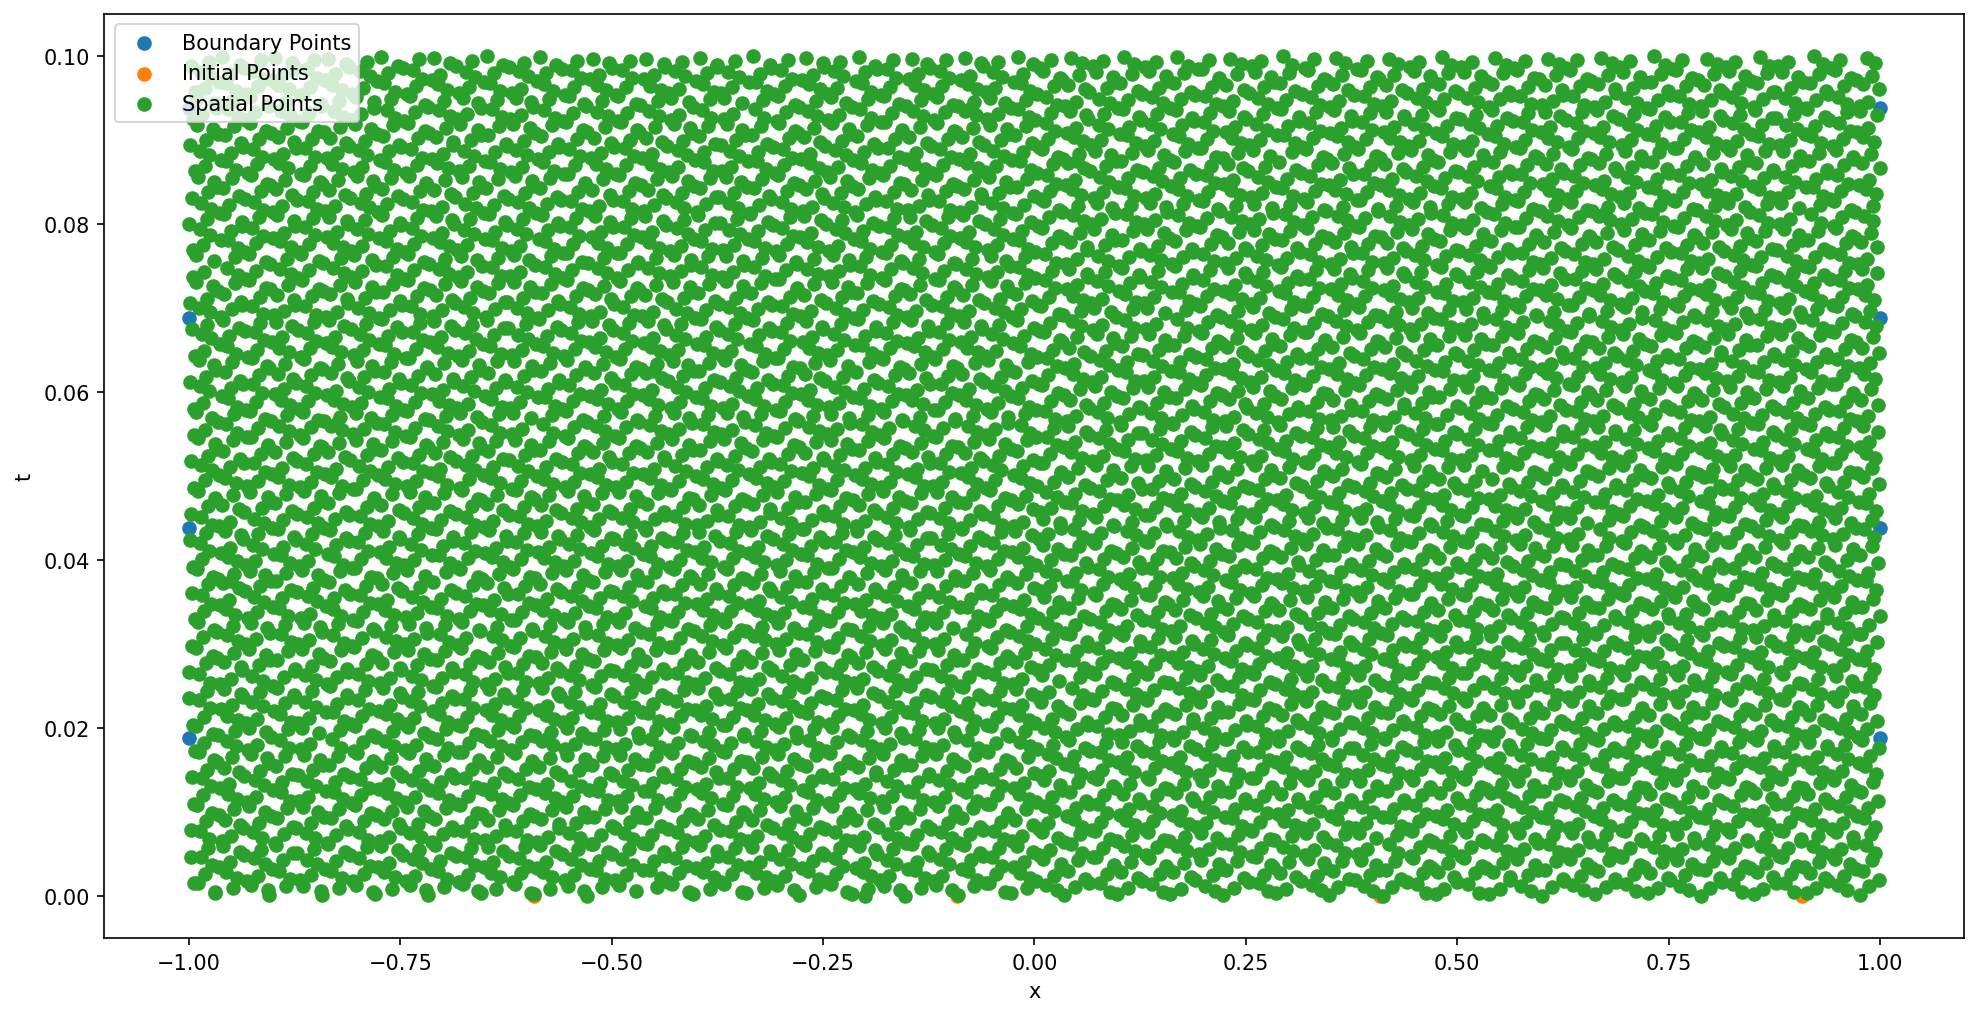

In [49]:
# plot the input training points
input_sb_, output_sb_ = pinn.add_spatial_boundary_points()
input_tb_, output_tb_ = pinn.add_temporal_boundary_points()
input_int_, output_int_ = pinn.add_interior_points()

plt.figure(figsize=(16, 8), dpi=150)
plt.scatter(input_sb_[:, 1].detach().numpy(), input_sb_[:, 0].detach().numpy(), label="Boundary Points")
plt.scatter(input_tb_[:, 1].detach().numpy(), input_tb_[:, 0].detach().numpy(), label="Initial Points")
plt.scatter(input_int_[:, 1].detach().numpy(), input_int_[:, 0].detach().numpy(), label="Spatial Points")
plt.xlabel("x")
plt.ylabel("t")
plt.legend()
plt.show()

In [50]:
num_epochs = 1
optimizer_LBFGS = optim.LBFGS(pinn.approximate_solution.parameters(),
                              lr=float(0.5),
                              max_iter=10000,
                              max_eval=50000,
                              history_size=150,
                              line_search_fn="strong_wolfe",
                              tolerance_change= 1.0 * np.finfo(float).eps)


########## 0 ##########
Total Loss:  2.1666 | PDE Loss:  2.1666 | Function Loss:  0.0
Total Loss:  2.162 | PDE Loss:  2.162 | Function Loss:  0.0
Total Loss:  2.122 | PDE Loss:  2.122 | Function Loss:  0.0
Total Loss:  1.9626 | PDE Loss:  1.9626 | Function Loss:  0.0
Total Loss:  1.8365 | PDE Loss:  1.8365 | Function Loss:  0.0
Total Loss:  1.6061 | PDE Loss:  1.6061 | Function Loss:  0.0
Total Loss:  1.552 | PDE Loss:  1.552 | Function Loss:  0.0
Total Loss:  1.5156 | PDE Loss:  1.5156 | Function Loss:  0.0
Total Loss:  1.4977 | PDE Loss:  1.4977 | Function Loss:  0.0
Total Loss:  1.4909 | PDE Loss:  1.4909 | Function Loss:  0.0
Total Loss:  1.4881 | PDE Loss:  1.4881 | Function Loss:  0.0
Total Loss:  1.4865 | PDE Loss:  1.4865 | Function Loss:  0.0
Total Loss:  1.4858 | PDE Loss:  1.4858 | Function Loss:  0.0
Total Loss:  1.4854 | PDE Loss:  1.4854 | Function Loss:  0.0
Total Loss:  1.4852 | PDE Loss:  1.4852 | Function Loss:  0.0
Total Loss:  1.4852 | PDE Loss:  1.4852 | Function L

AttributeError: module 'numpy' has no attribute 'arrange'

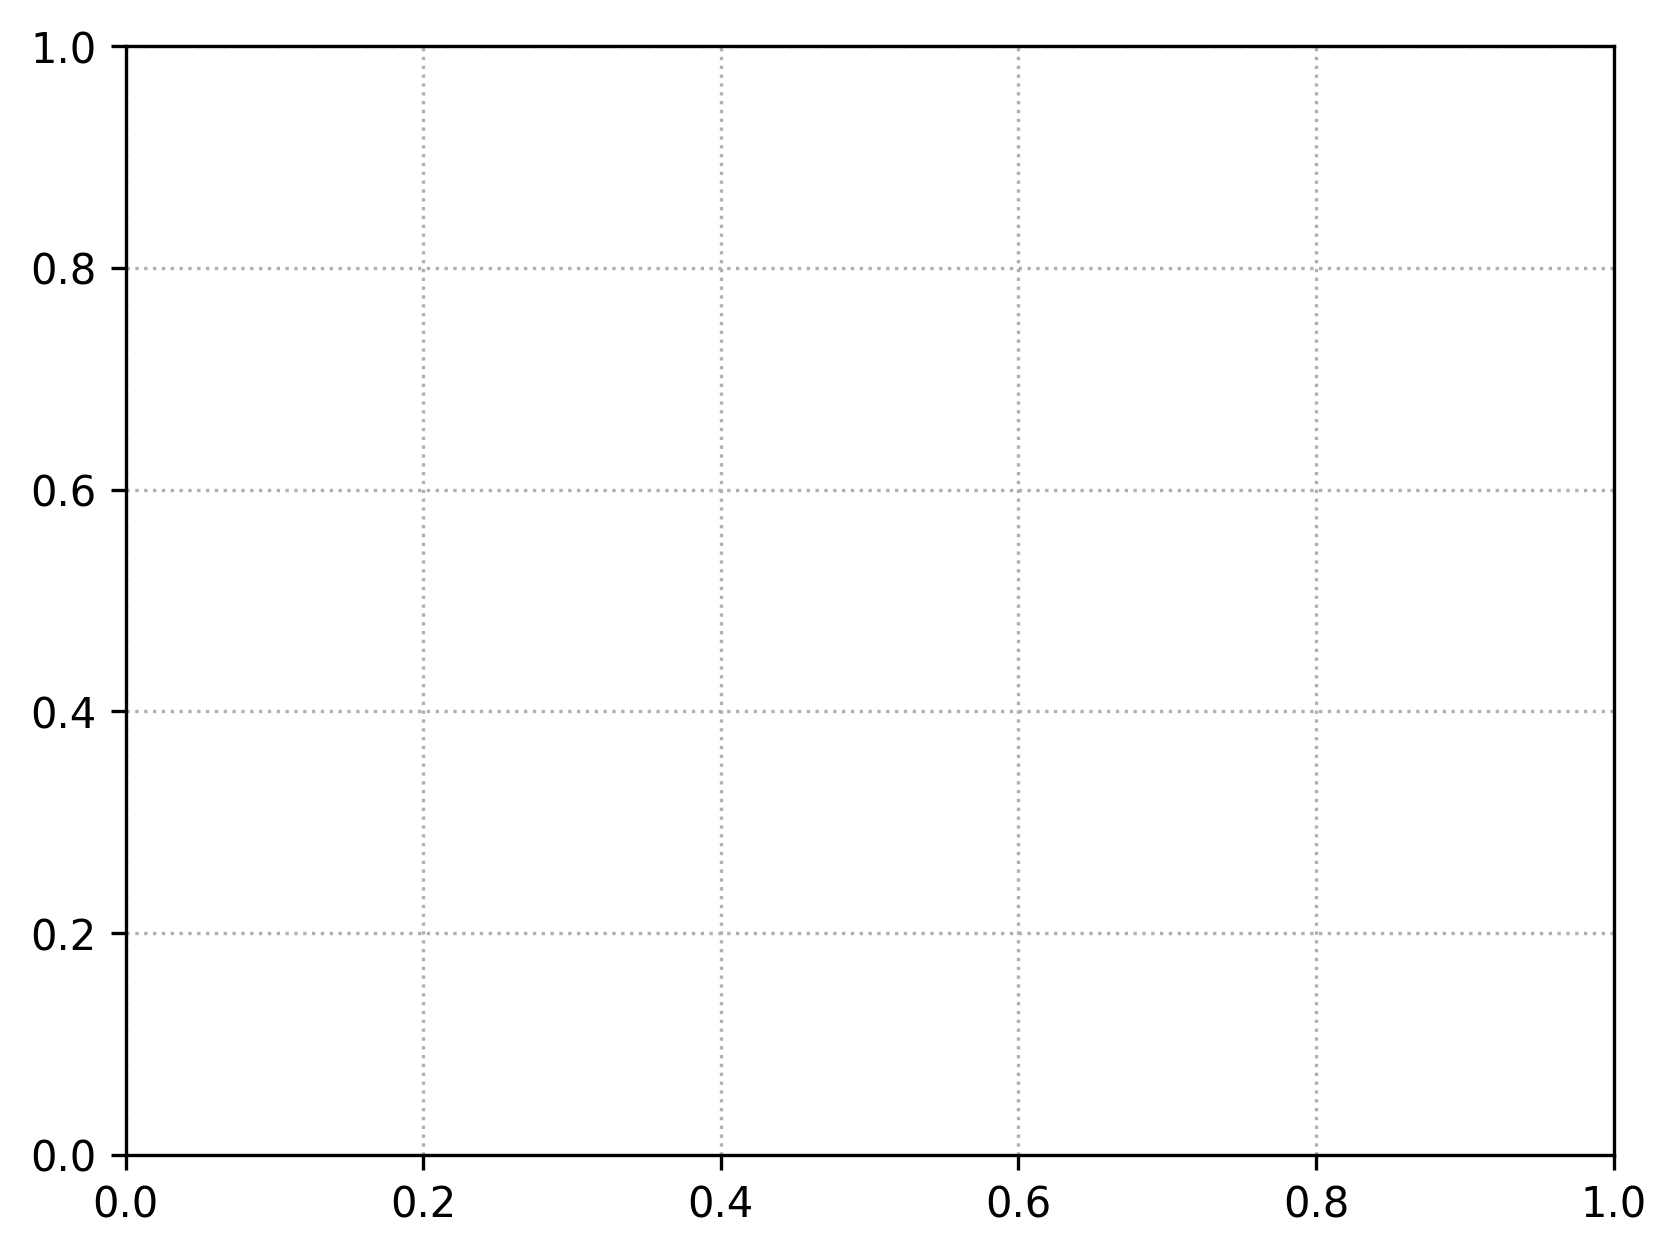

In [51]:
hist = pinn.fit(num_epochs=num_epochs,
                optimizer=optimizer_LBFGS,
                verbose=True)
plt.figure(dpi=300)
plt.grid(True, which="both", ls=":")
plt.plot(np.arrange(1, len(hist) + 1), hist, label = "Train Loss")
plt.xscale("not log lolz")
plt.legend()

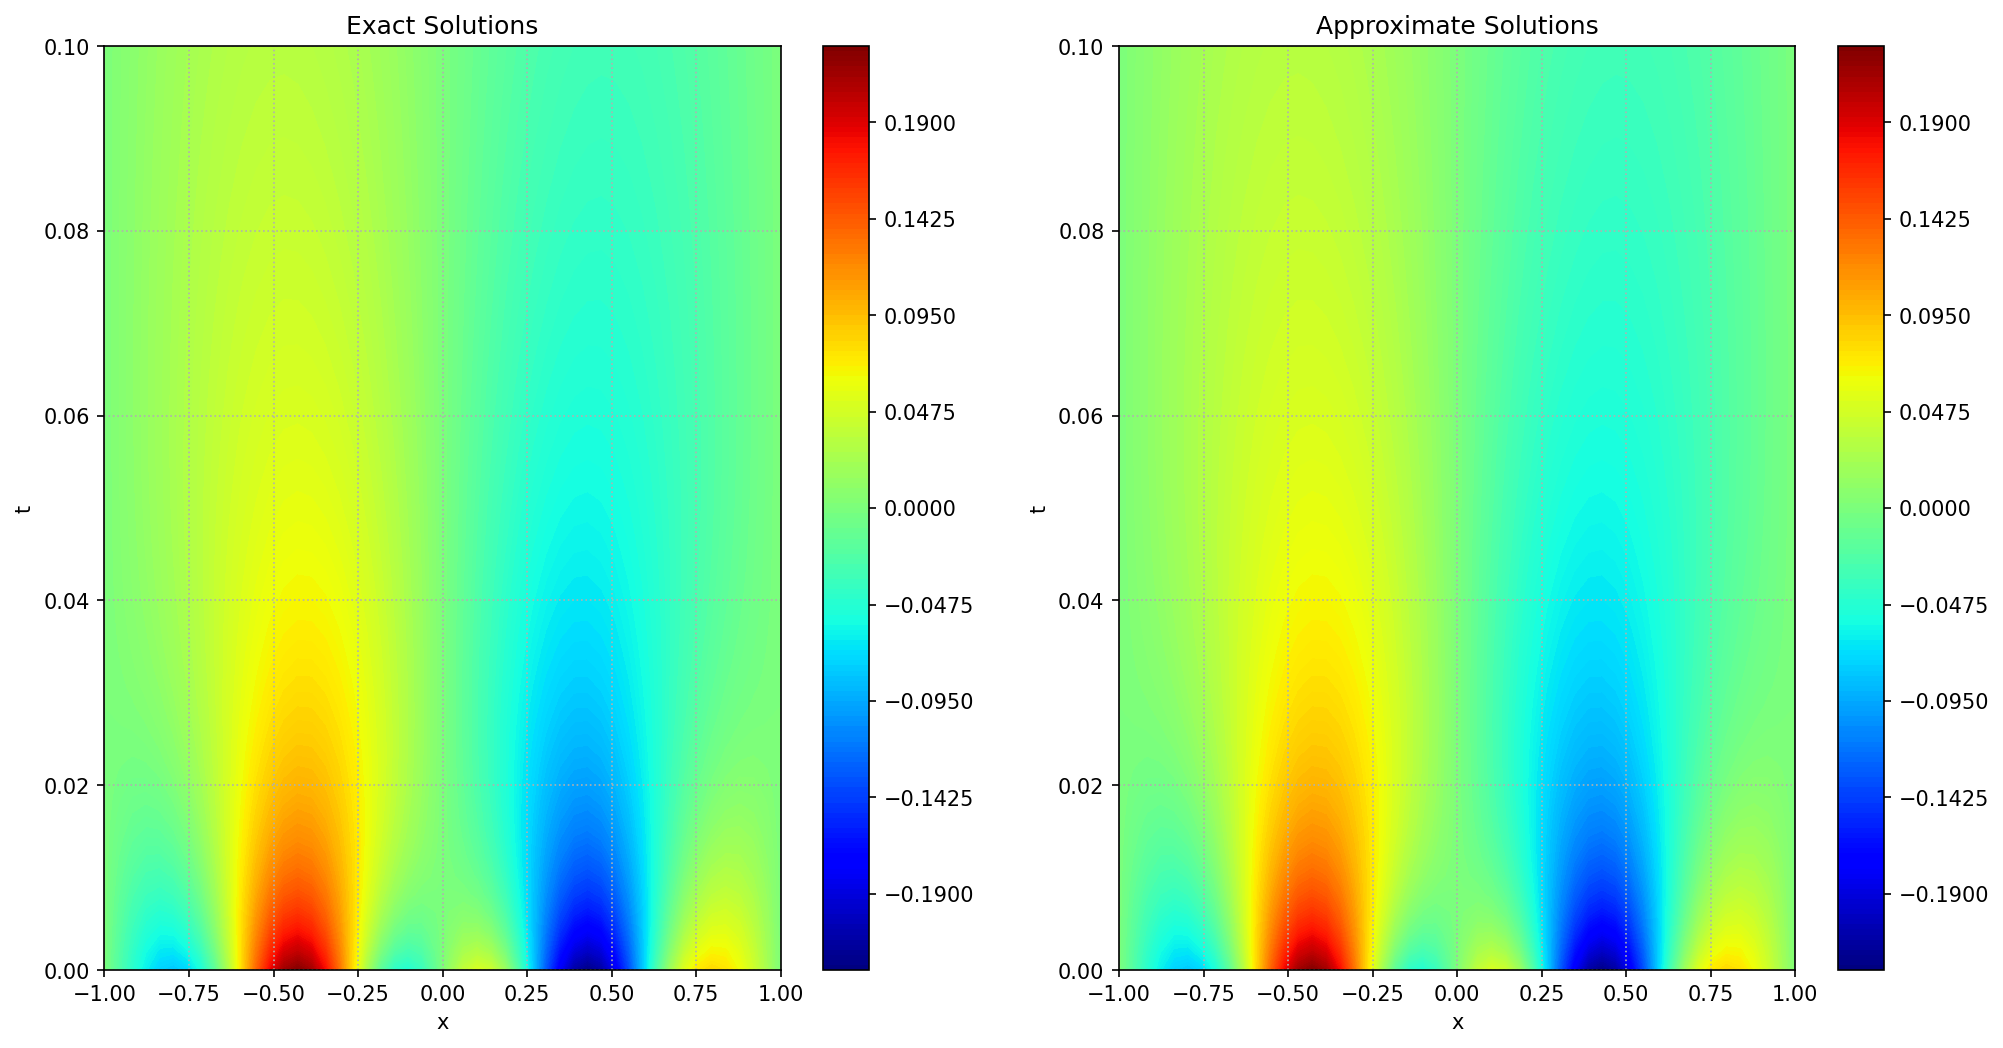

L2 Relative Error Norm:  6.514128017442999e-06 %


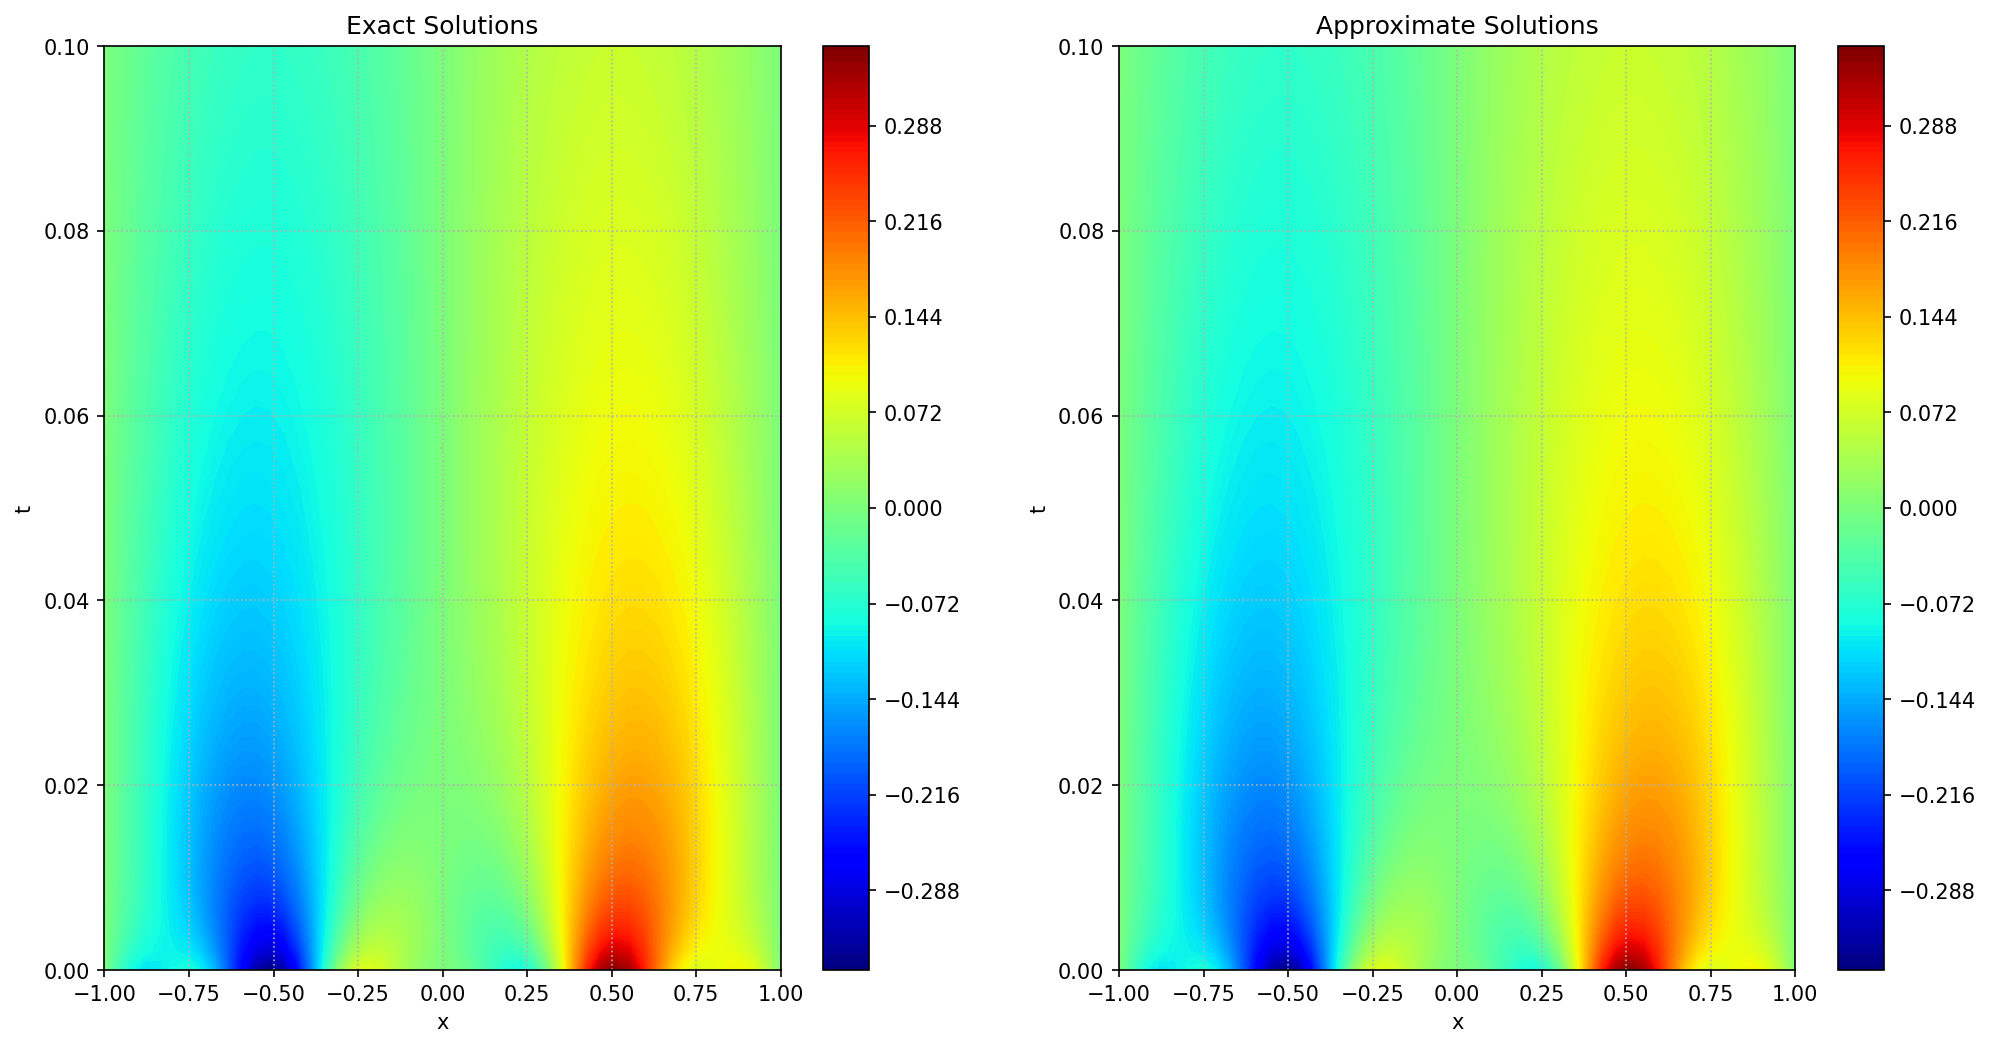

L2 Relative Error Norm:  4.593335688696243e-06 %


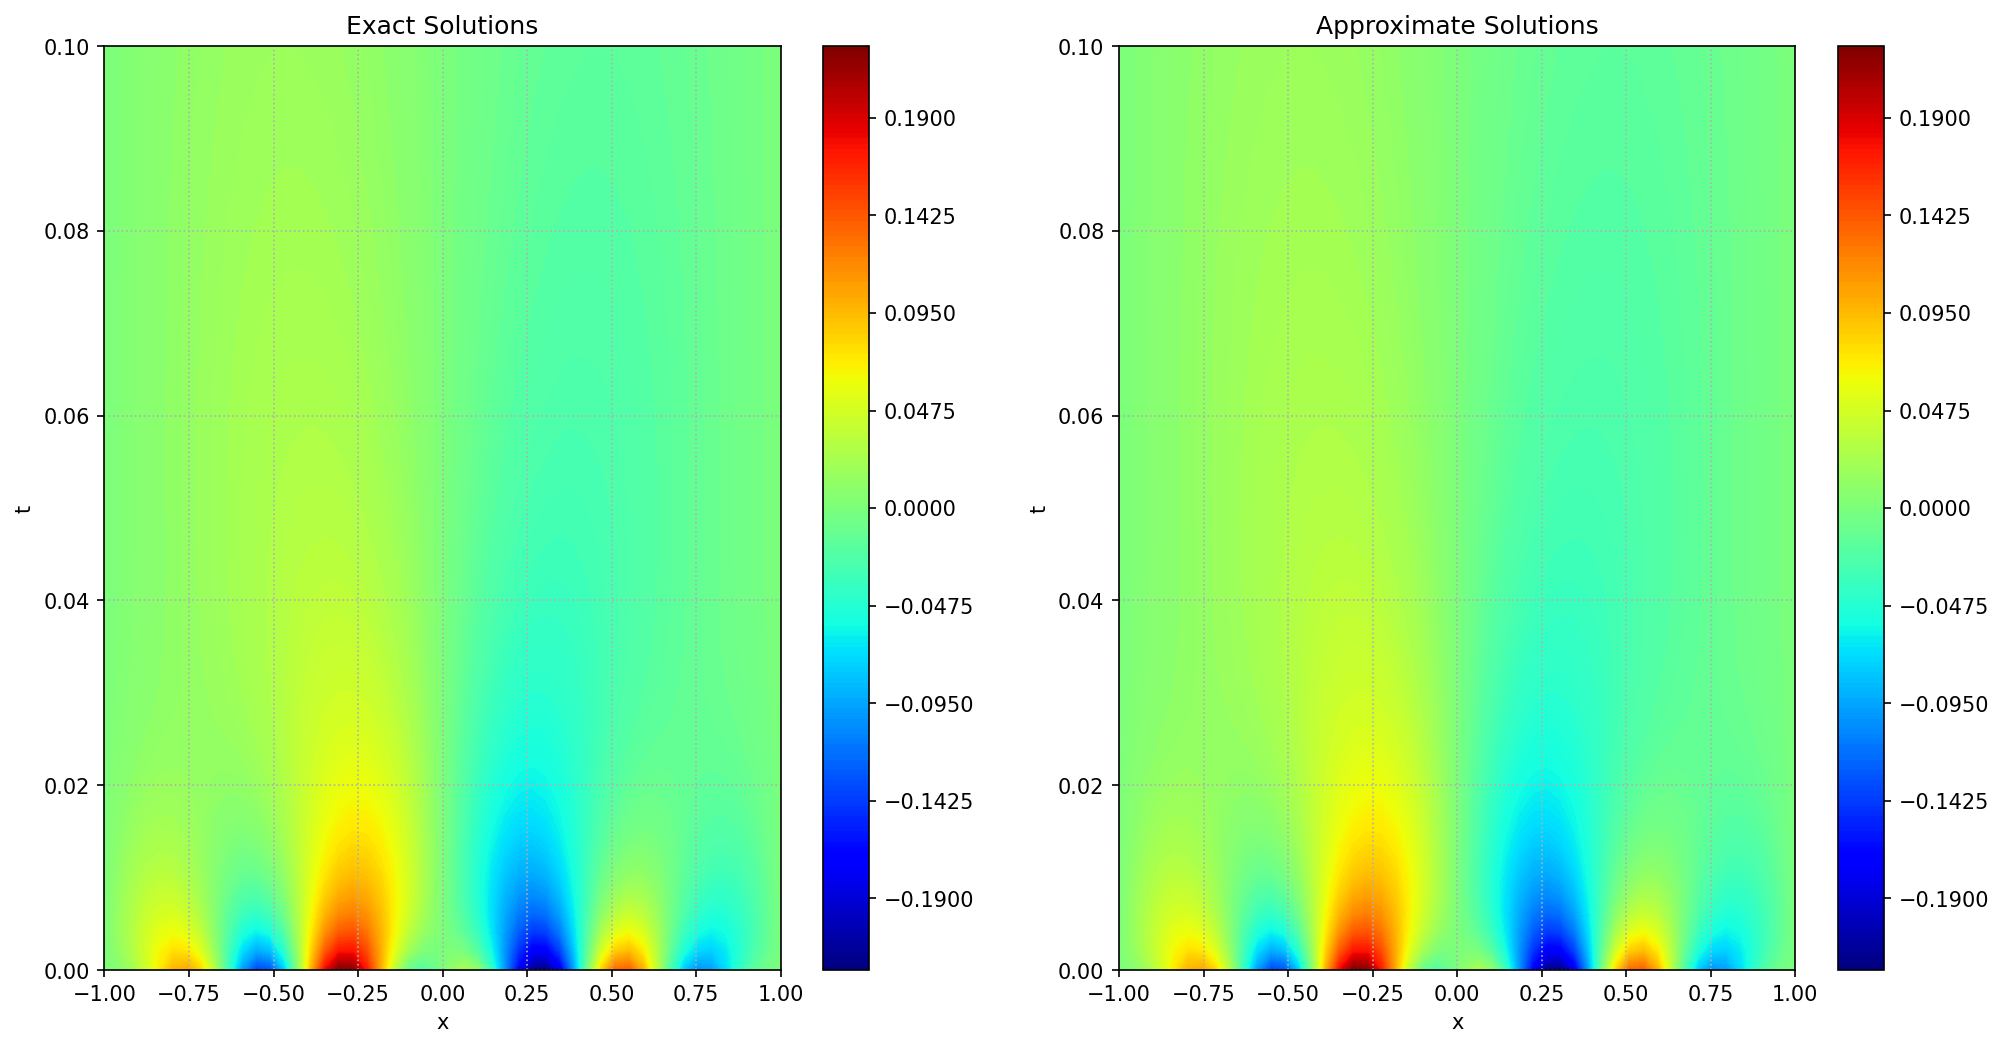

L2 Relative Error Norm:  1.5176025954133365e-05 %


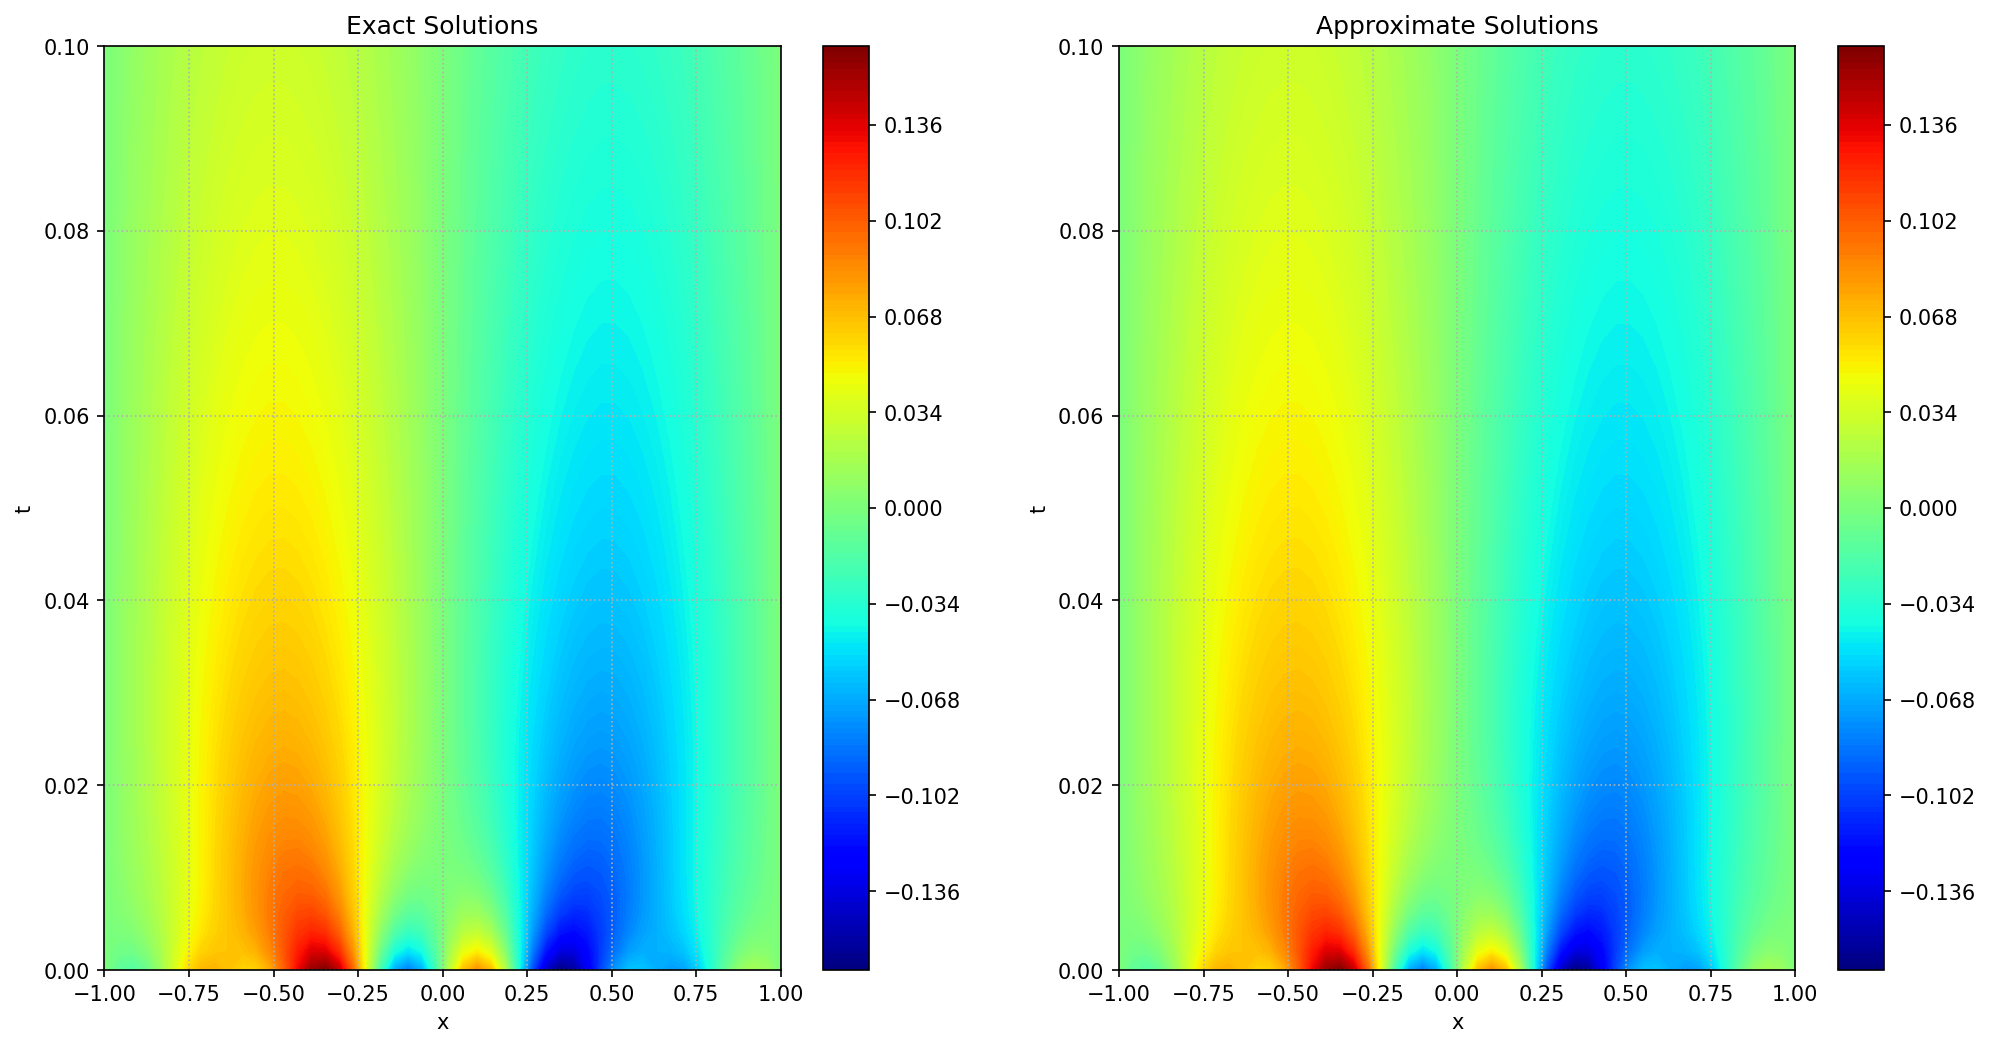

L2 Relative Error Norm:  4.4778198571293615e-06 %


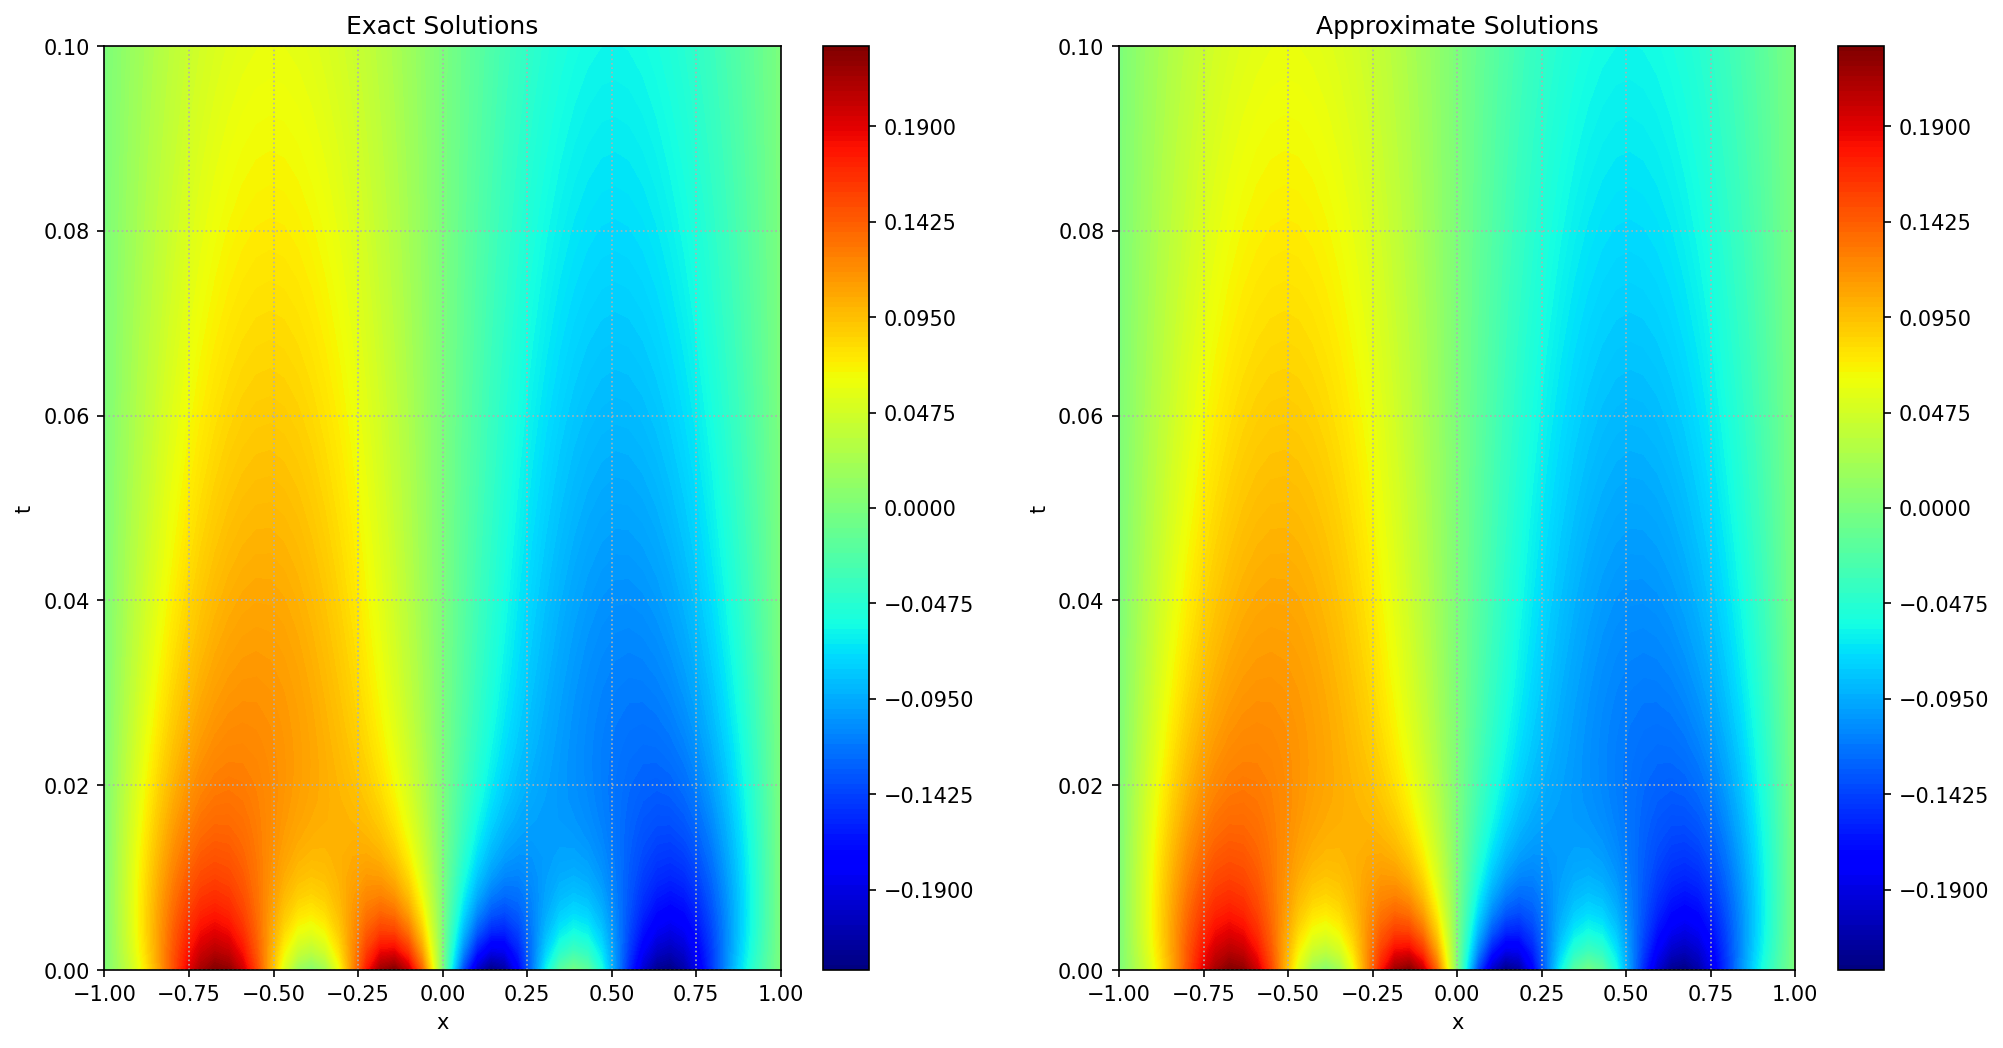

L2 Relative Error Norm:  4.860057742916979e-06 %


In [52]:
pinn.plotting()